# DeepFM

- 논문
  - DeepFM: A Factorization-Machine based Neural Network for CTR Prediction
- Tensorflow 구현 버전([링크](https://github.com/shenweichen/DeepCTR))
- PyTorch 버전([링크](https://github.com/shenweichen/DeepCTR-Torch))
- Factorization Machine 등 다양한 모델을 사용해 볼 수 있는 [torchfm 링크](https://pypi.org/project/torchfm/)
- Model architecture
- Click-through rate(CTR)을 예측하는 모델
- Factorization Machine과 Deep Learning 을 통합한 모델
- Wide & Deep 처럼 low-order featrue interaction과 high-order feature interaction 모두를 표현 가능함
- Wide & Deep 과 달리 FM 파트와 DL 파트가 같은 input을 공유하며 별도의 feature engineering이 필요없다는 장점이 있음

- 구조도

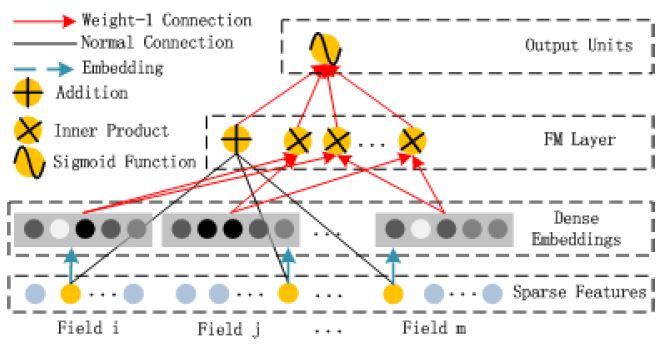

# Torchfm

In [ ]:
!pip install torchfm

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import os
from torch.utils.data import DataLoader
import torch.utils.data
import tqdm

In [ ]:
class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        # item index를 0부터 시작하는 것이 아니라, user 466에 이어 467부터 시작하도록 offset 설정
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long) 

    def forward(self, x):
        # |x| = (batch_size, num_fields)
        # x와 같은 shape로 offsets 생성 ex) [10, 30]의 경우, [10, 499]가 되도록 + [0, 466]를 하기 위함
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        print(x)
        
        return torch.sum(self.fc(x), dim=1) + self.bias


class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        #xavier_uniform 참고 자료: https://eda-ai-lab.tistory.com/404
        torch.nn.init.xavier_uniform_(self.embedding.weight.data) 

    def forward(self, x):
        # |x| = (batch_size, num_fields)
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)


class FactorizationMachine(torch.nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        # |x| = (batch_size, num_fields, embed_dim)

        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        
        # sum each fm result value
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix


class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        # |x| = (batch_size, embed_dim)
        return self.mlp(x)

In [ ]:
class DeepFactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of DeepFM.

    Reference:
        H Guo, et al. DeepFM: A Factorization-Machine based Neural Network for CTR Prediction, 2017.
    """

    def __init__(self, field_dims, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout)

    def forward(self, x):
        # |x| = (batch_size, num_fields)
        embed_x = self.embedding(x)
        # |embed_x| = (batch_size, num_fields, embed_dim)

        # deep part: concat each embedding vector    
        x = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim))
        # |x| = (batch_size, 1)
        return torch.sigmoid(x.squeeze(1))

## Load dataset and Train model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/data/kmrd/kmr_dataset/datafile/kmrd-small'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class KMRDDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        data = pd.read_csv(os.path.join(data_path,'rates.csv'))[:10000]
        
        user_to_index = {original: idx for idx, original in enumerate(data.user.unique())}
        movie_to_index = {original: idx for idx, original in enumerate(data.movie.unique())}
        data['user'] = data['user'].apply(lambda x: user_to_index[x])
        data['movie'] = data['movie'].apply(lambda x: movie_to_index[x])
        # [user, movie, rate] -> (user, movie, rate)
        data = data.to_numpy()[:, :3]

        self.items = data[:, :2].astype(np.int)  # -1 because ID begins from 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0,), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 9] = 0
        target[target > 9] = 1
        return target

In [ ]:
dataset = KMRDDataset(data_path=data_path)

In [ ]:
print(dataset.item_field_idx)
print(dataset.field_dims)
print(sum(dataset.field_dims))
print(torch.nn.Embedding(sum(dataset.field_dims), 16))
print(torch.nn.Parameter(torch.zeros((1,))))
print(np.array((0, *np.cumsum(dataset.field_dims)[:-1]), dtype=np.long))

[1]
[466 532]
998
Embedding(998, 16)
Parameter containing:
tensor([0.], requires_grad=True)
[  0 466]


In [ ]:
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_length, valid_length, test_length))

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=16)
valid_data_loader = DataLoader(valid_dataset, batch_size=16)
test_data_loader = DataLoader(test_dataset, batch_size=1)

In [ ]:
print(dataset.items)
print(dataset.targets)

[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [465  15]
 [465  15]
 [465 338]]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
model = DeepFactorizationMachineModel(dataset.field_dims, embed_dim=16, mlp_dims=(16, 16), dropout=0.2)
model

DeepFactorizationMachineModel(
  (linear): FeaturesLinear(
    (fc): Embedding(998, 1)
  )
  (fm): FactorizationMachine()
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(998, 16)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-6)

In [ ]:
log_interval = 100

model.train()
total_loss = 0
tk0 = tqdm.tqdm(train_data_loader, smoothing=0, mininterval=1.0)
for i, (fields, target) in enumerate(tk0):
    # |fields| = (batch_size, 2), |target| = (batch_size, 1) 
    # 2 of fields = [user_index, item_index], 1 of target = [rating]
    # fields, target = fields.to(device), target.to(device)
    y = model(fields)
    loss = criterion(y, target.float())
    model.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    if (i + 1) % log_interval == 0:
        tk0.set_postfix(loss=total_loss / log_interval)
        total_loss = 0



  0%|          | 0/500 [00:00<?, ?it/s]

tensor([[ 57, 227],
        [263,  10],
        [ 58, 240],
        [ 42,  59],
        [ 25, 304],
        [105, 261],
        [216, 385],
        [464, 219],
        [110,  85],
        [170,  65],
        [384, 219],
        [123, 359],
        [ 44, 218],
        [333,  43],
        [ 86, 105],
        [465, 336]])
tensor([[ 57, 693],
        [263, 476],
        [ 58, 706],
        [ 42, 525],
        [ 25, 770],
        [105, 727],
        [216, 851],
        [464, 685],
        [110, 551],
        [170, 531],
        [384, 685],
        [123, 825],
        [ 44, 684],
        [333, 509],
        [ 86, 571],
        [465, 802]])
tensor([[465, 216],
        [ 25, 116],
        [127, 151],
        [241,  29],
        [389,  13],
        [213,  19],
        [ 91,  92],
        [ 79,   2],
        [ 95,  32],
        [170,  94],
        [ 44,  35],
        [ 57,  30],
        [428,  65],
        [110, 246],
        [334,  65],
        [278,  92]])
tensor([[465, 682],
        [ 25, 582



  0%|          | 0/500 [00:00<?, ?it/s, loss=0.575]

tensor([[ 92, 341],
        [  9, 161],
        [105, 224],
        [224, 494],
        [104, 220],
        [320,  59],
        [ 44,   3],
        [465, 221],
        [ 92, 402],
        [170,  98],
        [ 68, 220],
        [ 52,  29],
        [ 95, 188],
        [430,  92],
        [130, 178],
        [224, 187]])
tensor([[ 92, 807],
        [  9, 627],
        [105, 690],
        [224, 960],
        [104, 686],
        [320, 525],
        [ 44, 469],
        [465, 687],
        [ 92, 868],
        [170, 564],
        [ 68, 686],
        [ 52, 495],
        [ 95, 654],
        [430, 558],
        [130, 644],
        [224, 653]])
tensor([[312, 231],
        [170, 462],
        [231, 108],
        [161,  37],
        [291, 105],
        [145, 332],
        [ 95,  27],
        [138, 104],
        [263, 219],
        [170,  40],
        [ 29,  29],
        [430,  17],
        [110,  49],
        [216,  45],
        [ 73,  31],
        [ 79, 335]])
tensor([[312, 697],
        [170, 928



  0%|          | 0/500 [00:00<?, ?it/s, loss=0.531]

 46%|████▌     | 228/500 [00:01<00:01, 227.29it/s, loss=0.531]

tensor([[  3, 145],
        [110, 102],
        [205, 305],
        [454, 226],
        [161,  37],
        [  0,  74],
        [214, 286],
        [262,  37],
        [428, 227],
        [306,  85],
        [465,   8],
        [ 70, 219],
        [140, 117],
        [184,  56],
        [430, 196],
        [369, 108]])
tensor([[  3, 611],
        [110, 568],
        [205, 771],
        [454, 692],
        [161, 503],
        [  0, 540],
        [214, 752],
        [262, 503],
        [428, 693],
        [306, 551],
        [465, 474],
        [ 70, 685],
        [140, 583],
        [184, 522],
        [430, 662],
        [369, 574]])
tensor([[299,   3],
        [ 44,  20],
        [240,  61],
        [ 67,  70],
        [444, 220],
        [312, 394],
        [123,  29],
        [428,  31],
        [ 19,   3],
        [ 29,  20],
        [192,  85],
        [106,  93],
        [169, 203],
        [110, 179],
        [ 19, 248],
        [ 73,  62]])
tensor([[299, 469],
        [ 44, 486



 46%|████▌     | 228/500 [00:01<00:01, 171.01it/s, loss=0.528]

tensor([[ 23,  78],
        [224,  23],
        [ 44,  62],
        [158, 434],
        [140, 323],
        [145, 105],
        [365,  37],
        [ 92, 193],
        [353, 135],
        [ 44, 218],
        [170,  52],
        [146,  83],
        [ 81, 101],
        [158, 144],
        [ 68,  49],
        [224,  82]])
tensor([[ 23, 544],
        [224, 489],
        [ 44, 528],
        [158, 900],
        [140, 789],
        [145, 571],
        [365, 503],
        [ 92, 659],
        [353, 601],
        [ 44, 684],
        [170, 518],
        [146, 549],
        [ 81, 567],
        [158, 610],
        [ 68, 515],
        [224, 548]])
tensor([[ 74, 221],
        [432,  56],
        [ 20, 139],
        [ 23, 287],
        [ 77,  29],
        [316, 229],
        [ 20, 175],
        [323,  75],
        [463,  85],
        [107,  43],
        [428, 375],
        [193,  95],
        [181,  14],
        [ 95, 188],
        [326,  96],
        [262,  13]])
tensor([[ 74, 687],
        [432, 522



 46%|████▌     | 228/500 [00:01<00:02, 128.02it/s, loss=0.509]

tensor([[224, 882],
        [ 92, 803],
        [159, 547],
        [ 86, 587],
        [ 83, 570],
        [167, 606],
        [  4, 662],
        [ 29, 681],
        [242, 561],
        [123, 904],
        [310, 503],
        [326, 854],
        [119, 512],
        [224, 490],
        [465, 686],
        [ 95, 558]])
tensor([[158, 179],
        [ 82, 431],
        [ 44,  62],
        [ 70, 283],
        [169,  33],
        [ 76, 297],
        [ 92, 397],
        [ 45, 239],
        [ 92, 359],
        [ 92, 162],
        [  3,  22],
        [170, 472],
        [ 95, 219],
        [ 92, 150],
        [110, 218],
        [105, 111]])
tensor([[158, 645],
        [ 82, 897],
        [ 44, 528],
        [ 70, 749],
        [169, 499],
        [ 76, 763],
        [ 92, 863],
        [ 45, 705],
        [ 92, 825],
        [ 92, 628],
        [  3, 488],
        [170, 938],
        [ 95, 685],
        [ 92, 616],
        [110, 684],
        [105, 577]])
tensor([[ 73,  18],
        [ 58, 100



 91%|█████████ | 456/500 [00:02<00:00, 221.90it/s, loss=0.509]

tensor([[ 58, 280],
        [179,  14],
        [438, 398],
        [170, 315],
        [345, 345],
        [ 73, 267],
        [116,  23],
        [ 25,  99],
        [303, 349],
        [400, 163],
        [ 44, 138],
        [ 18,  62],
        [ 44,  92],
        [ 58,   2],
        [384,  85],
        [ 92, 121]])
tensor([[ 58, 746],
        [179, 480],
        [438, 864],
        [170, 781],
        [345, 811],
        [ 73, 733],
        [116, 489],
        [ 25, 565],
        [303, 815],
        [400, 629],
        [ 44, 604],
        [ 18, 528],
        [ 44, 558],
        [ 58, 468],
        [384, 551],
        [ 92, 587]])
tensor([[  3, 119],
        [454, 240],
        [ 92, 156],
        [ 73, 397],
        [130, 271],
        [170, 399],
        [430, 108],
        [384,  35],
        [123,  56],
        [430, 458],
        [182, 169],
        [ 57,  91],
        [112, 103],
        [233,  20],
        [158, 271],
        [359,   8]])
tensor([[  3, 585],
        [454, 706



100%|██████████| 500/500 [00:02<00:00, 221.79it/s, loss=0.536]


tensor([[110, 771],
        [ 44, 479],
        [130, 566],
        [ 40, 705],
        [  3, 624],
        [182, 627],
        [140, 652],
        [438, 604],
        [293, 479],
        [ 94, 566],
        [ 86, 893],
        [146, 699],
        [ 74, 485],
        [ 28, 569],
        [464, 559],
        [318, 818]])
tensor([[146,  49],
        [226,  13],
        [372,  85],
        [ 42, 218],
        [ 29, 323],
        [ 58, 307],
        [ 95, 244],
        [ 28, 222],
        [ 66,  29],
        [201,  65],
        [205,  68],
        [  3, 134],
        [ 22,  19],
        [438, 224],
        [ 58, 102],
        [ 29, 143]])
tensor([[146, 515],
        [226, 479],
        [372, 551],
        [ 42, 684],
        [ 29, 789],
        [ 58, 773],
        [ 95, 710],
        [ 28, 688],
        [ 66, 495],
        [201, 531],
        [205, 534],
        [  3, 600],
        [ 22, 485],
        [438, 690],
        [ 58, 568],
        [ 29, 609]])
tensor([[ 76, 160],
        [ 95, 45